In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pyedflib
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, irfft
from imblearn.under_sampling import RandomUnderSampler
from scipy.signal import butter, filtfilt, find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from joblib import dump, load

In [147]:
data = pd.read_parquet('data/data.parquet')
data

,emb,label
0,"[0.050875000000000004, 0.0418125, 0.0518125000...",none
1,"[-0.0885625, -0.1311875, -0.148875, -0.12975, ...",none
2,"[0.185375, 0.2161875, 0.1673125, 0.1468125, 0....",none
3,"[-0.141625, -0.149, -0.1784375, -0.2235, -0.21...",none
4,"[0.21106250000000001, 0.210875, 0.2288125, 0.2...",none
...,...,...
518359,"[0.07981250000000001, 0.079125, 0.0873125, 0.0...",swd
518360,"[0.04025, 0.0349375, 0.03625, 0.01325, 0.02162...",swd
518361,"[0.07225, 0.063625, 0.0226875, 0.0071875, 0.02...",swd
518362,"[0.05375, 0.058875000000000004, 0.08325, 0.096...",swd


In [32]:
data['emb'] = data['emb'].map(lambda x: np.sum(x.reshape((3, -1)), axis=0))
data['emb']

0         [0.2185625, 0.1883125, 0.214625, 0.293625, 0.3...
1         [0.408875, 0.3946875, 0.4164375, 0.39937500000...
2         [0.236125, 0.2361875, 0.245875, 0.2139375, 0.1...
3         [-0.200875, -0.12662500000000002, -0.074125000...
4         [0.22225, 0.2618125, 0.279, 0.3253749999999999...
                                ...                        
129589    [0.01475, 0.0176875, 0.0325625, -0.00412500000...
129590    [0.174375, 0.12331249999999999, 0.098125, 0.14...
129591    [0.040375, 0.007187500000000001, 0.0605, 0.055...
129592    [-0.02375, -0.0499375, -0.107125, -0.1225625, ...
129593    [0.12106250000000002, 0.135, 0.1823125, 0.1984...
Name: emb, Length: 129594, dtype: object

In [38]:
rus = RandomUnderSampler(sampling_strategy={'none': 1000}, random_state=13)
X, y = rus.fit_resample(data, data['label'])

<Axes: >

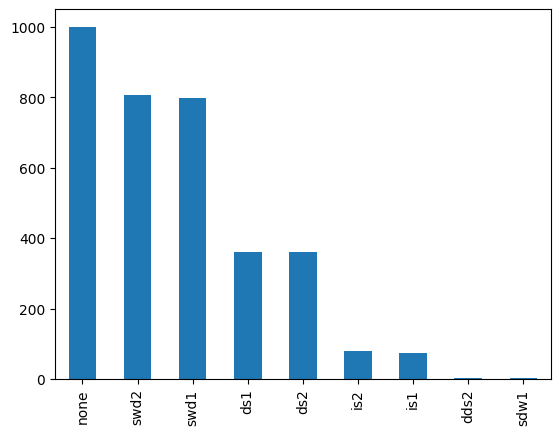

In [39]:
X['label'].value_counts().plot(kind='bar')

# KNN

In [40]:
first = X[(X['label'] == 'none') | (X['label'] == 'swd1') | (X['label'] == 'ds1') | (X['label'] == 'is1')]
first

,emb,label
176,"[0.466875, 0.4600625, 0.433375, 0.468624999999...",ds1
177,"[-0.2821875, -0.251, -0.2049375, -0.1756875, -...",ds1
341,"[-0.045375000000000006, -0.0008124999999999938...",ds1
342,"[-0.1483125, -0.200375, -0.22856250000000003, ...",ds1
1473,"[0.1549375, 0.18937500000000002, 0.2074375, 0....",ds1
...,...,...
128848,"[-0.096125, -0.06512500000000002, -0.088937499...",swd1
128849,"[0.22999999999999998, 0.19424999999999998, 0.1...",swd1
129506,"[-0.12618749999999998, -0.143875, -0.078000000...",swd1
129507,"[-0.159375, -0.209125, -0.211125, -0.2464375, ...",swd1


In [110]:
train, test = train_test_split(first, test_size=0.33, random_state=42, stratify=first['label'])

In [117]:
start_model = KNeighborsClassifier(n_neighbors=1)
start_model.fit(np.array(list(first['emb'].values)), first['label'])

KNeighborsClassifier(n_neighbors=1)

In [112]:
dump(neigh, 'start_model.joblib') 

['start_model.joblib']

In [74]:
sum(neigh.predict(np.array(list(test['emb'].values))) == test['label']) / len(test)

0.5609756097560976

In [76]:
f1_score(neigh.predict(np.array(list(test['emb'].values))), test['label'], average='micro')

0.5609756097560976

<Axes: >

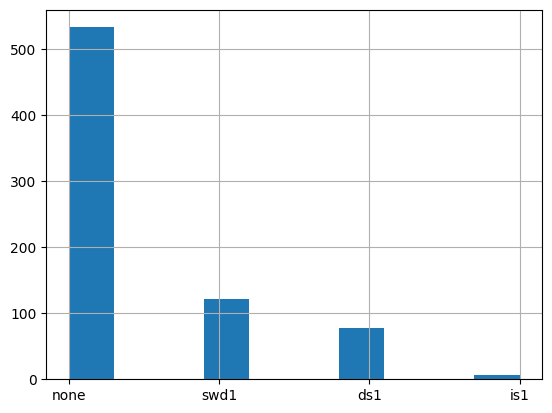

In [80]:
pd.Series(neigh.predict(np.array(list(test['emb'].values)))).hist()

<Axes: >

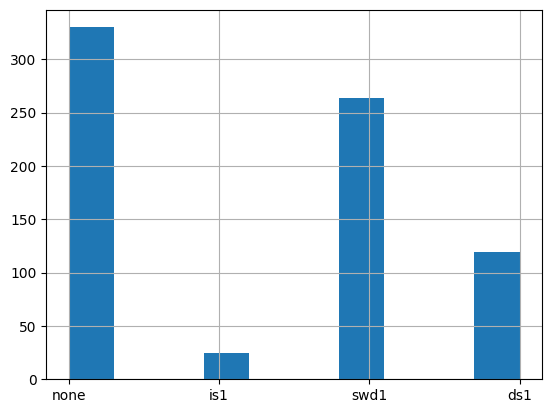

In [79]:
test['label'].hist()

In [81]:
second = X[(X['label'] == 'none') | (X['label'] == 'swd2') | (X['label'] == 'ds2') | (X['label'] == 'is2')]
second

,emb,label
260,"[-0.013624999999999998, 0.010624999999999997, ...",ds2
261,"[-0.6280625000000001, -0.54325, -0.50150000000...",ds2
494,"[-0.5730000000000001, -0.6001875, -0.6088125, ...",ds2
495,"[0.6189375, 0.598875, 0.5909375, 0.612, 0.6049...",ds2
1499,"[0.3925, 0.4853125, 0.506, 0.499875, 0.5019375...",ds2
...,...,...
128850,"[0.2891875, 0.5893125, 0.69975, 0.6988125, 0.7...",swd2
128851,"[-0.210625, -0.398875, -0.5966875, -0.67756250...",swd2
128852,"[-0.044500000000000005, -0.055499999999999994,...",swd2
129513,"[-0.237875, -0.1906875, -0.12506250000000002, ...",swd2


In [83]:
train, test = train_test_split(second, test_size=0, random_state=13, stratify=second['label'])

In [116]:
end_model = KNeighborsClassifier(n_neighbors=1)
end_model.fit(np.array(list(second['emb'].values)), second['label'])

KNeighborsClassifier(n_neighbors=1)

In [105]:
sum(neigh.predict(np.array(list(test['emb'].values))) == test['label']) / len(test)

0.5525606469002695

<Axes: >

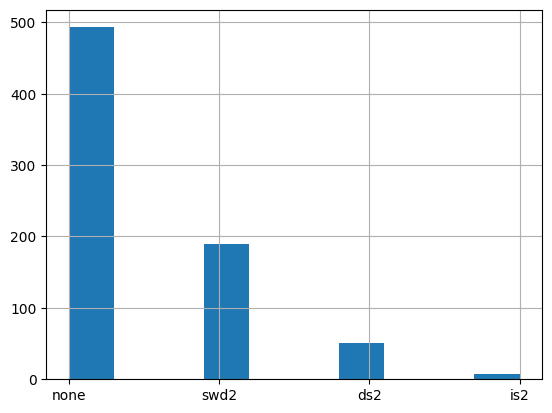

In [106]:
pd.Series(neigh.predict(np.array(list(test['emb'].values)))).hist()

<Axes: >

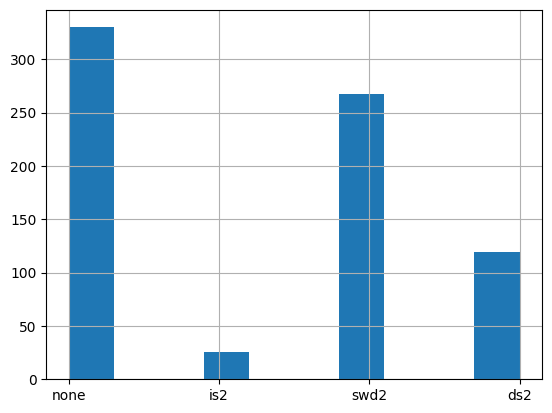

In [107]:
test['label'].hist()

In [109]:
dump(neigh, 'end_model.joblib') 

['end_model.joblib']

In [ ]:
def predict():
    for i in range(0, len()):

# Metric

In [114]:
file_name = 'data/golden/Ati4x1_15m_H2O_6h_edited.edf'
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
n_a = f.annotations_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

In [115]:
annotations = list(f.readAnnotations())
annotations[0] = annotations[0] / (f.getFileDuration() / sigbufs.shape[1])
annotations

[array([ 171400.,  184180., 2698120., 2705430., 2874740., 2879860.,
        5692550., 5716010., 8002510., 8038110., 8059800., 8090150.,
        8090190., 8098990.]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1.]),
 array(['ds1', 'ds2', 'is1', 'is2', 'is1', 'is2', 'ds1', 'ds2', 'ds1',
        'ds2', 'ds1', 'ds2', 'is1', 'is2'], dtype='<U3')]

In [200]:
def jaccard_metric(data, ground_trouth):
    gr = []
    d = []
    if 'is' in ground_trouth:
        gr.append(np.array(ground_trouth) == 'is')
        d.append(np.array(data) == 'is')
        
    
    if 'ds' in ground_trouth:
        gr.append(np.array(ground_trouth) == 'ds')
        d.append(np.array(data) == 'ds')
    
    if 'swd' in ground_trouth:
        gr.append(np.array(ground_trouth) == 'swd')
        d.append(np.array(data) == 'swd')
    
    gr.append(np.array(ground_trouth) == 'none')
    d.append(np.array(data) == 'none')
    
    result = 0
    for i in range(len(d)):
        result += jaccard_score(gr[i], d[i])
    
    return result/len(d)

In [143]:
def predprocessing(chunk):
    return np.sum(chunk, axis=0)


def predict(chunk, time, mode):
    data = predprocessing(chunk).reshape((1, -1))
    
    if mode == 'start':
        model = start_model
    else:
        model = end_model
    pred = model.predict(data)
    
    if pred != 'none' and mode == 'start':
        mode = 'end'
    elif pred != 'none':
        mode = 'start'
        
    return {'x': time, 'y': pred, 'mode': mode}

In [145]:
result = []
mode = 'start'
for i in tqdm(range(0, len(sigbufs[0]), 1000)):
    if i + 1000 < len(sigbufs[0]):
        data = predict(sigbufs[:, i: i+1000], i+750, mode)
        mode = data['mode']
        result.append((data['x'], data['y']))

100%|██████████| 8641/8641 [00:43<00:00, 198.97it/s]


In [149]:
result[0]

(750, array(['none'], dtype=object))

In [151]:
mode = 'none'

for j, i in enumerate(result, 0):
    if i[1][0] != 'none' and i[1][0][-1] == '1':
        mode = i[1][0][:-1]
        
    result[j] = (result[j][0], mode)
    
    if i[1][0][-1] == '2':
        mode = 'none'

In [178]:
result1 = [i[0] for i in result if i[1] != 'none']
result2 = [i[1] for i in result if i[1] != 'none']

In [186]:
data = []
mode = 'none'

for i in tqdm(range(len(sigbufs[0]))):
    for j in range(0, len(result1[:-1]), 2):
        if i >= int(result1[j]) and int(result1[j + 1]) >= i:
            mode = result2[j]
            break
        
        if int(result1[j + 1]) < i:
            mode = 'none'
            break
            
        
    data.append(mode)

100%|██████████| 8640400/8640400 [01:36<00:00, 89208.48it/s] 


<Axes: >

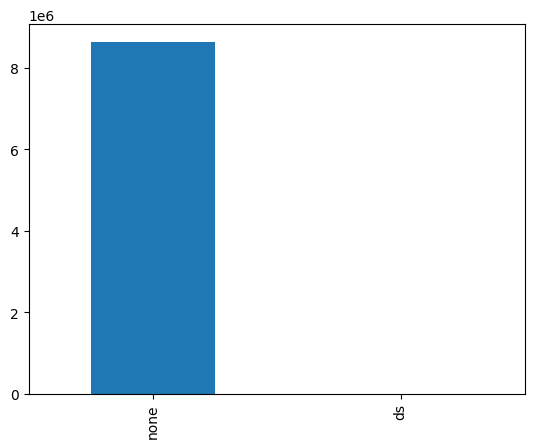

In [187]:
pd.Series(data).value_counts().plot(kind='bar')

In [174]:
ground_trouth = ['none'] * len(sigbufs[0])

        for j in range(0, len(annotations[0]), 2):
            ground_trouth[int(str(annotations[0][j]).split('.')[0]): int(str(annotations[0][j + 1]).split('.')[0])+1] = annotations[2][j][:-1]

100%|██████████| 8640400/8640400 [00:49<00:00, 173916.85it/s]


<Axes: >

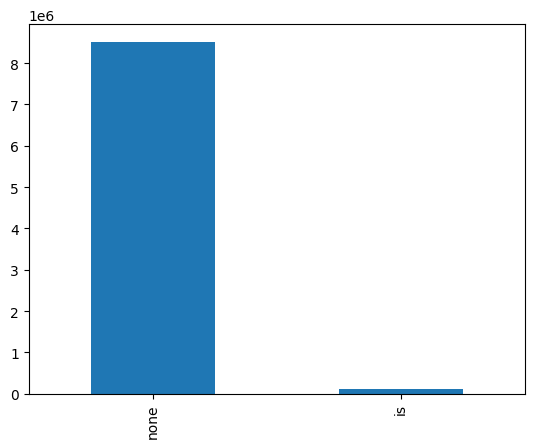

In [188]:
pd.Series(ground_trouth).value_counts().plot(kind='bar')

In [201]:
jaccard_metric(data, ground_trouth)

0.49279963890560624